<a href="https://colab.research.google.com/github/KetiLaz/TechPro_Project/blob/main/Final_Assignment_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
from google.colab import drive
drive.mount('drive/')

Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sb
import re
from scipy import stats
import numpy as np

# DATA PREPROCESSING
We will start by checking the dataset for any missing values, wrong entries etc. Correcting where possible and deleting the entries where correction is not an option.

In [133]:
retail_sales = pd.read_csv('/content/drive/MyDrive/TechPro/adjusted_retail_sales_data_v2.csv')
retail_sales.head()

,SalesDate,ProductCategory,SalesAmount,CustomerAge,CustomerGender,CustomerLocation,ProductRatings
0,2023-10-15,Home Appliances,609,22,Male,USA,4
1,2023-09-16,Clothing,1367,22,Female,Australia,5
2,2022-09-06,Electronics,1736,22,Male,UK,2
3,2023-02-24,Female,1838,35,Clothing,India,2
4,2022-09-24,Home Appliances,1829,35,Male,UK,5


In [134]:
retail_sales.shape

(1000, 7)

In [135]:
#Check for NaN, the unique variables of columns

retail_sales.isna().values.any() # There are NaNs in the dataset
retail_sales.columns[retail_sales.isna().any()].tolist() # The NaNs are in the CustomerLocation column
retail_sales['CustomerLocation'].isna().sum() #There are in total 2 NaNs in the column

for col in retail_sales:
  print(retail_sales[col].unique())

# From the unique values returned we can see that there are some wrong variables like 'Female' in the ProductCategory column or
# ages over 100 in the CustomerAge column and strings instead of integers in the ProductRatings etc

['2023-10-15' '2023-09-16' '2022-09-06' '2023-02-24' '2022-09-24'
 '2023-08-15' '2022-07-19' '12-09-2023' '2022-08-07' '2023-12-04'
 '2022-06-19' '2023-12-30' '2022-03-13' '2022-12-13' '2023-11-08'
 '2022-03-09' '2022-10-19' '2023-05-23' '2023-12-22' '2022-05-24'
 '2022-04-22' '2023-11-06' '2023-06-11' '2023-05-24' '2023-08-10'
 '2023-11-27' '2023-03-19' '2022-08-28' '2023-12-19' '2023-05-21'
 '2023-05-17' '2023-09-26' '2023-12-26' '2023-11-23' '2023-06-10'
 '2022-07-26' '2022-11-21' '2022-05-21' '2022-11-28' '2023-04-05'
 '2022-04-02' '2023-01-21' '2022-12-29' '2023-02-20' '2023-01-04'
 '2023-01-23' '2022-11-01' '2023-08-27' '2023-11-30' '2023-04-11'
 '2023-07-10' '2022-01-04' '2023-12-06' '2023-04-30' '2023-05-09'
 '2022-12-25' '2023-05-03' '2022-01-19' '2023-09-15' '2023-03-23'
 '2023-05-11' '2022-10-01' '2023-03-24' '2023-06-13' '2023-08-09'
 '2022-06-14' '2023-10-31' '2023-07-08' '2022-12-31' '2023-11-22'
 '2023-06-01' '2023-09-17' '10/07/2023' '2022-03-23' '2023-06-08'
 '2023-04-

In [136]:
#Check if the variables of the column SalesDate are in the correct format (YYYY-MM-DD)

date_regex = re.compile(r'^\d{4}-\d{2}-\d{2}$')

print(len(retail_sales[~retail_sales['SalesDate'].str.contains(date_regex)]))

#So there are three entries that are not in the correct format and these are the following:

retail_sales[~retail_sales['SalesDate'].str.contains(date_regex)]

3


,SalesDate,ProductCategory,SalesAmount,CustomerAge,CustomerGender,CustomerLocation,ProductRatings
7,12-09-2023,Clothing,1656,35,Male,USA,3
73,10/07/2023,Home Appliances,710,35,Female,India,4
91,24-11-2023,Home Appliances,994,35,Female,USA,5


In [137]:
#We will change the SalesDate column from string to a pandas datetime and change the format of all the entries to YYYY-MM-DD

retail_sales['SalesDate'] = pd.to_datetime(retail_sales['SalesDate']) #Change the column to datetime

retail_sales['SalesDate'] = retail_sales['SalesDate'].dt.strftime('%Y-%m-%d') #Change the format to YYYY-MM-DD

retail_sales[~retail_sales['SalesDate'].str.contains(date_regex)] #If we check the column again we will see that there are no entries with the wrong date format

#Because the strftime returns an object (string) and not Datetime we will convert the column again
retail_sales['SalesDate'] = pd.to_datetime(retail_sales['SalesDate'], format = '%Y-%m-%d')
retail_sales['SalesDate']


<ipython-input-137-f23d520f4318>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  retail_sales['SalesDate'] = pd.to_datetime(retail_sales['SalesDate']) #Change the column to datetime


0     2023-10-15
1     2023-09-16
2     2022-09-06
3     2023-02-24
4     2022-09-24
         ...    
995   2023-12-02
996   2023-02-02
997   2023-07-30
998   2023-01-05
999   2022-11-18
Name: SalesDate, Length: 1000, dtype: datetime64[ns]

In [138]:
#Let's see the earliest and latest date in the SalesDate column

retail_sales['SalesDate'].min() # 2022-01-02
retail_sales['SalesDate'].max() # 2023-12-31

Timestamp('2023-12-31 00:00:00')

In [139]:
#Count the 'wrong' variables per column

print(retail_sales['ProductCategory'].value_counts())


print('\n', retail_sales['CustomerGender'].value_counts())


print('\n', retail_sales['CustomerAge'].value_counts())


print('\n', retail_sales['ProductRatings'].value_counts())

Electronics        357
Clothing           326
Home Appliances    316
Female               1
Name: ProductCategory, dtype: int64

 Male              488
Female            483
Unknown            23
Non-binary          4
Clothing            1
Did not answer      1
Name: CustomerGender, dtype: int64

 22     506
35     483
105      2
200      1
20       1
95       1
2        1
112      1
100      1
101      1
180      1
120      1
Name: CustomerAge, dtype: int64

 3      220
2      207
1      196
4      189
5      185
10       1
two      1
one      1
Name: ProductRatings, dtype: int64


In [140]:
#For starters we will drop the two NaNs from the CustomerLocation column
retail_sales = retail_sales.dropna()
retail_sales.shape

(998, 7)

In [141]:
#Change the 'one' and 'two' to 1 and 2 in the ProductRatings column and drop the row with the variable 10
retail_sales['ProductRatings'] = retail_sales['ProductRatings'].replace(['one', 'two'], ['1','2'])
mask_rating = retail_sales['ProductRatings'] == '10'
retail_sales = retail_sales[~mask_rating]
print(retail_sales['ProductRatings'].unique())
print(retail_sales.shape)

['4' '5' '2' '3' '1']
(997, 7)


In [142]:
#Remove the Female entry from the column ProductCategory
mask_category = retail_sales['ProductCategory'] == 'Female'
retail_sales = retail_sales[~mask_category]
print(retail_sales['ProductCategory'].unique())
print(retail_sales.shape)

['Home Appliances' 'Clothing' 'Electronics']
(996, 7)


In [143]:
#Remove anything that is not Male, Female or Non Binary from the CustomerGender column

retail_sales = retail_sales.drop(retail_sales[retail_sales['CustomerGender'] == 'Clothing'].index)
retail_sales = retail_sales.drop(retail_sales[retail_sales['CustomerGender'] == 'Did not answer'].index)
retail_sales = retail_sales.drop(retail_sales[retail_sales['CustomerGender'] == 'Unknown'].index)

retail_sales.shape

(972, 7)

In [144]:
#Remove the ages over 95 and the entry of 2 from the column CustomerAge

retail_sales = retail_sales[(retail_sales['CustomerAge'] > 18) & (retail_sales['CustomerAge'] < 95)]

print(retail_sales['CustomerAge'].value_counts())
print(retail_sales.shape)


22    494
35    467
20      1
Name: CustomerAge, dtype: int64
(962, 7)


In [145]:
#Check if the column SalesAmount has anything other than numeric values. If yes fix them. Change from string to integer.

retail_sales[~retail_sales['SalesAmount'].str.match('[0-9]*$')] #Using regex to find rows in the SalesAmount column that contains other characters other than numbers



,SalesDate,ProductCategory,SalesAmount,CustomerAge,CustomerGender,CustomerLocation,ProductRatings
18,2023-12-22,Clothing,779%,35,Male,Canada,5
65,2023-08-09,Electronics,3-0,35,Female,Japan,3
72,2023-09-17,Home Appliances,3-00,35,Male,USA,3
290,2023-09-19,Clothing,3-0,22,Female,India,1
926,2023-11-08,Electronics,3-0,35,Female,UK,3


In [146]:
#There are five data entries in the SalesAmount column that are wrong and we will correct
retail_sales['SalesAmount'] = retail_sales['SalesAmount'].replace(['779%', '3-0', '3-00'], ['779','30', '300'])

retail_sales[~retail_sales['SalesAmount'].str.match('[0-9]*$')] #checking again there are no wrong entries

#Change the column SalesAmount from string to integer
retail_sales['SalesAmount'] = retail_sales['SalesAmount'].astype(int)
print(retail_sales['SalesAmount'].dtype)

int64


<ipython-input-146-bca8ae441c69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_sales['SalesAmount'] = retail_sales['SalesAmount'].replace(['779%', '3-0', '3-00'], ['779','30', '300'])
<ipython-input-146-bca8ae441c69>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_sales['SalesAmount'] = retail_sales['SalesAmount'].astype(int)


# Descriptive statistcs.
We will try to understand sales trends, customer demographics and product performance by calculating basic statistics. We will group average sales per product category, age distribution of customers and typical product ratings to get a feel for the sales trens.

We will use the describe() function of pandas. For numeric data, the result’s index will include count, mean, std, min, max as well as lower, 50 and upper percentiles. By default the lower percentile is 25 and the upper percentile is 75. The 50 percentile is the same as the median. For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. The top is the most common value. The freq is the most common value’s frequency. Timestamps also include the first and last items.

In [147]:
for col in retail_sales:
  print('\n',retail_sales[col].describe())


 count                     962
unique                    541
top       2023-07-16 00:00:00
freq                        6
first     2022-01-02 00:00:00
last      2023-12-31 00:00:00
Name: SalesDate, dtype: object

 count             962
unique              3
top       Electronics
freq              344
Name: ProductCategory, dtype: object

 count    9.620000e+02
mean     2.926663e+03
std      6.042327e+04
min      2.200000e+01
25%      5.100000e+02
50%      9.860000e+02
75%      1.428000e+03
max      1.875000e+06
Name: SalesAmount, dtype: float64

 count    962.000000
mean      28.308732
std        6.502966
min       20.000000
25%       22.000000
50%       22.000000
75%       35.000000
max       35.000000
Name: CustomerAge, dtype: float64

 count      962
unique       3
top       Male
freq       479
Name: CustomerGender, dtype: object

 count     962
unique      6
top       USA
freq      199
Name: CustomerLocation, dtype: object

 count     962
unique      5
top         3
freq      213


<ipython-input-147-bc3476e56a2b>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print('\n',retail_sales[col].describe())


In [148]:
#Search for outliers in SalesAmount using the z_score
#Calculate the z-score
z_score = np.abs(stats.zscore(retail_sales['SalesAmount']))

#Identify the outliers with a z-score greater than 3
sales_outliers = retail_sales[z_score > 3]
print(sales_outliers) #There is only one outlier

#Replacing the outlier with the median value of the column
retail_sales.loc[z_score > 3, 'SalesAmount'] = retail_sales['SalesAmount'].median()


     SalesDate ProductCategory  SalesAmount  CustomerAge CustomerGender  \
991 2022-02-13     Electronics      1875000           22           Male   

    CustomerLocation ProductRatings  
991        Australia              2  


From the describe function we gather some information about our dataset:


*   Electronics are the most frequent product category
*   Most of the buyers identify as Male
*   Most of the buyers are located in the USA
*   The average age of the customers is 28
*   The most frequent product rating is 3







In [149]:
#Show the average sales per product category with the groupby() function

retail_sales[['SalesAmount', 'ProductCategory']].groupby('ProductCategory').mean()

#We can see that there is not much of a difference among the product categories

,SalesAmount
ProductCategory,
Clothing,975.679487
Electronics,976.494186
Home Appliances,984.019608


In [150]:
#Average sales per age distribution

retail_sales[['SalesAmount', 'CustomerAge']].groupby('CustomerAge').mean()

#Customers aged 22 seem to spend more as Customers, the mean of the customers aged 20 is virtual because we know that we have only one entry

,SalesAmount
CustomerAge,
20,1755.000000
22,973.688259
35,982.182013


In [151]:
#Average sales per product ratings

retail_sales[['SalesAmount', 'ProductRatings']].groupby('ProductRatings').mean()

#Suprisingly most of the sales are of the products rated as 5.

,SalesAmount
ProductRatings,
1,1004.154639
2,969.595000
3,917.746479
4,995.879121
5,1017.231214


In [152]:
#Average sales per customer location

retail_sales[['SalesAmount', 'CustomerLocation']].groupby('CustomerLocation').mean()

,SalesAmount
CustomerLocation,
Australia,928.991071
Canada,920.968586
India,1065.419753
Japan,900.514563
UK,1018.723077
USA,992.371859


# Data visualization

Sales trends, customer demographics and product performance.

In [154]:
#Sort the dataset in the ascending order of date
retail_sales = retail_sales.sort_values(by = 'SalesDate')

#Extract year and month from the SalesDate column
retail_sales['YearMonth'] = retail_sales['SalesDate'].dt.to_period('M')

#Group by product category and date (year_month) with the total amount of sales
group_category_date = retail_sales.groupby(['ProductCategory', 'YearMonth'])['SalesAmount'].sum().reset_index()
group_category_date



,ProductCategory,YearMonth,SalesAmount
0,Clothing,2022-01,15591
1,Clothing,2022-02,11346
2,Clothing,2022-03,13680
3,Clothing,2022-04,12520
4,Clothing,2022-05,17796
...,...,...,...
67,Home Appliances,2023-08,13029
68,Home Appliances,2023-09,12898
69,Home Appliances,2023-10,14792
70,Home Appliances,2023-11,10257


Text(0.5, 1.0, 'Total Sales by Month')

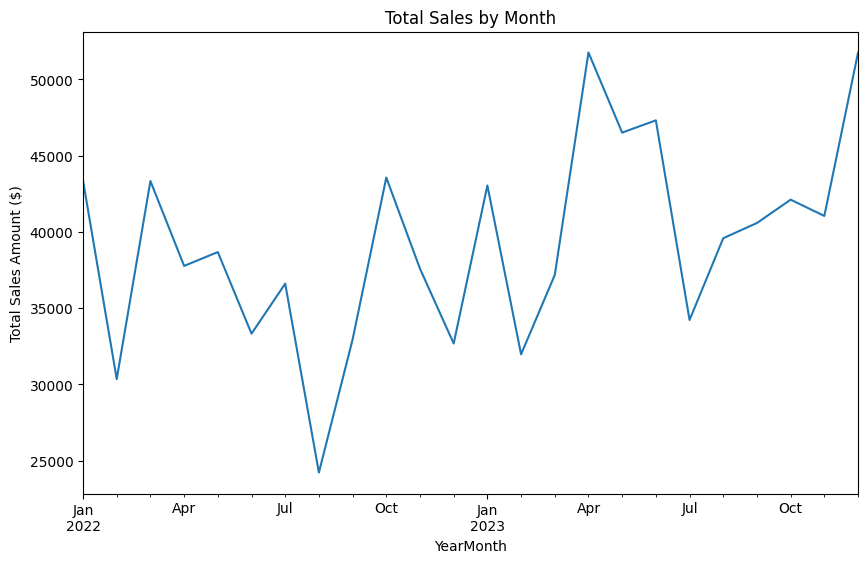

In [171]:
#First let's see the total amount of sales by month
fig, ax = plt.subplots(figsize=(10, 6))
retail_sales.groupby('YearMonth')['SalesAmount'].sum().plot()
ax.set_ylabel('Total Sales Amount ($)')
ax.set_title('Total Sales by Month')

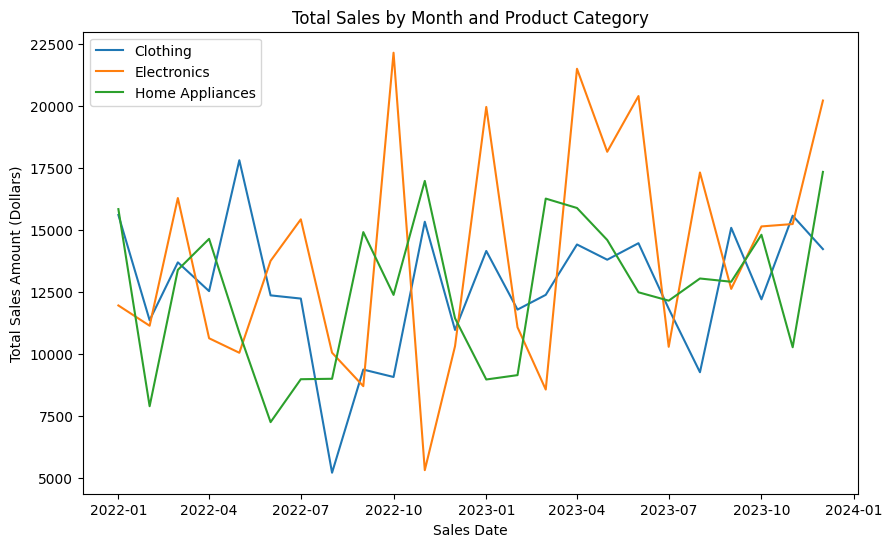

In [159]:
# Create a time series plot for each product category
fig, ax = plt.subplots(figsize=(10, 6))

for category, group in group_category_date.groupby('ProductCategory'):
    ax.plot(group['YearMonth'].dt.to_timestamp(), group['SalesAmount'], label=category)

# Set labels and title
ax.set_xlabel('Sales Date')
ax.set_ylabel('Total Sales Amount ($)')
ax.set_title('Total Sales by Month and Product Category')

# Show legend
ax.legend()

# Show the plot
plt.show()


Text(0, 0.5, 'Total Sales Amount ($)')

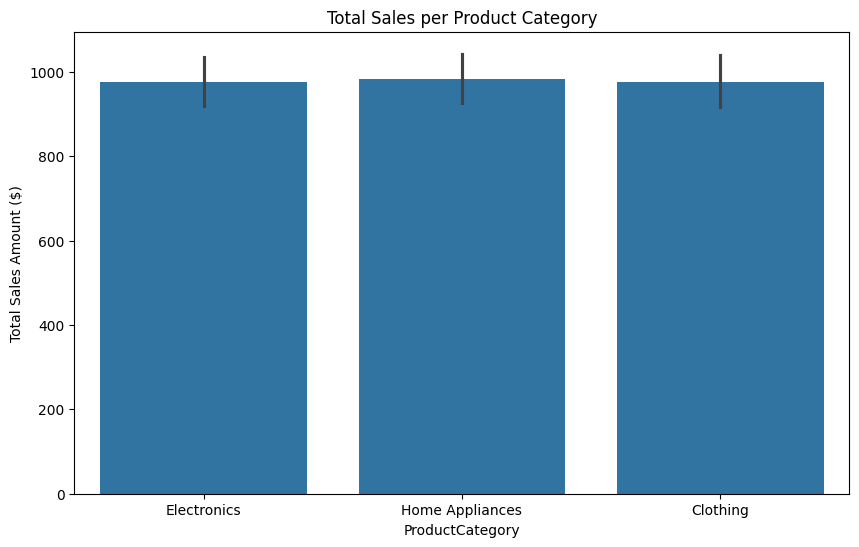

In [172]:
#Create a barplot for the total sales per product category
fig, ax = plt.subplots(figsize=(10, 6))

# Sales by Product Category
sb.barplot(x='ProductCategory', y='SalesAmount', data=retail_sales)
ax.set_title('Total Sales per Product Category')
ax.set_ylabel('Total Sales Amount ($)')

In [161]:
#Lets visualise the total sales per product rating throughout our dateframe
#Group by product rating and date (year_month) with the total amount of sales
group_rating_date = retail_sales.groupby(['ProductRatings', 'YearMonth'])['SalesAmount'].sum().reset_index()
group_rating_date


,ProductRatings,YearMonth,SalesAmount
0,1,2022-01,7235
1,1,2022-02,4560
2,1,2022-03,7664
3,1,2022-04,6993
4,1,2022-05,15537
...,...,...,...
115,5,2023-08,6541
116,5,2023-09,11453
117,5,2023-10,4635
118,5,2023-11,5773


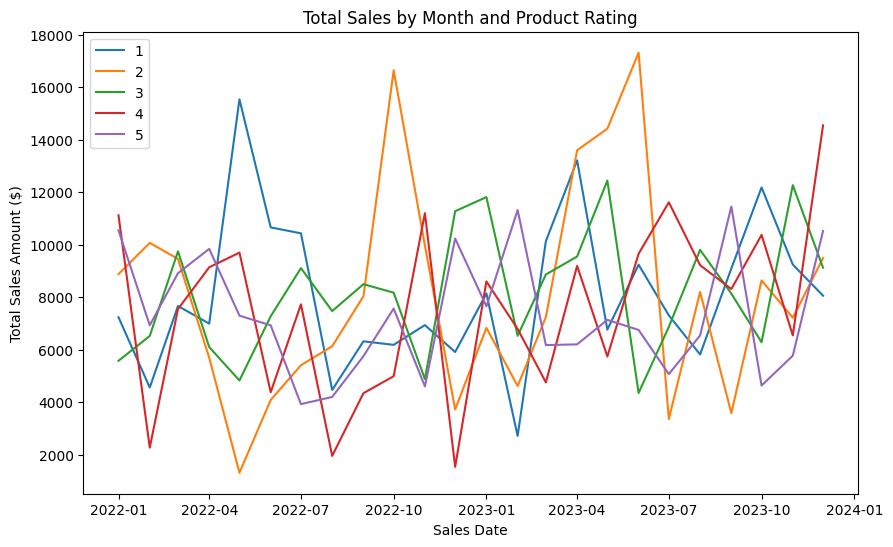

In [163]:
# Create a time series plot for each product rating
fig, ax = plt.subplots(figsize=(10, 6))

for ratings, group in group_rating_date.groupby('ProductRatings'):
    ax.plot(group['YearMonth'].dt.to_timestamp(), group['SalesAmount'], label=ratings)

# Set labels and title
ax.set_xlabel('Sales Date')
ax.set_ylabel('Total Sales Amount ($)')
ax.set_title('Total Sales by Month and Product Rating')

# Show legend
ax.legend()

# Show the plot
plt.show()

Text(0, 0.5, 'Total Sales Amount ($)')

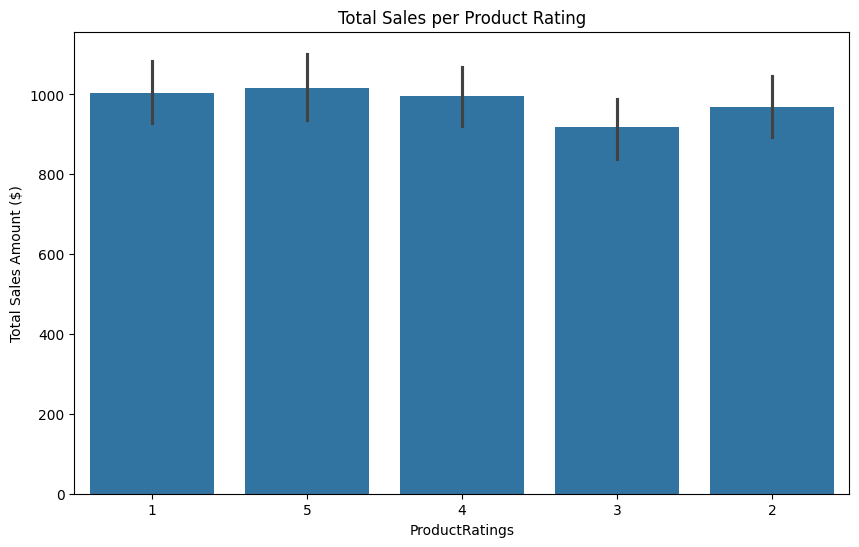

In [174]:
#Create a barplot for the total sales per product rating
fig, ax = plt.subplots(figsize=(10, 6))

# Sales by Product Category
sb.barplot(x='ProductRatings', y='SalesAmount', data=retail_sales)
ax.set_title('Total Sales per Product Rating')
ax.set_ylabel('Total Sales Amount ($)')

Describe the trends

Text(0.5, 0, 'Customer Location')

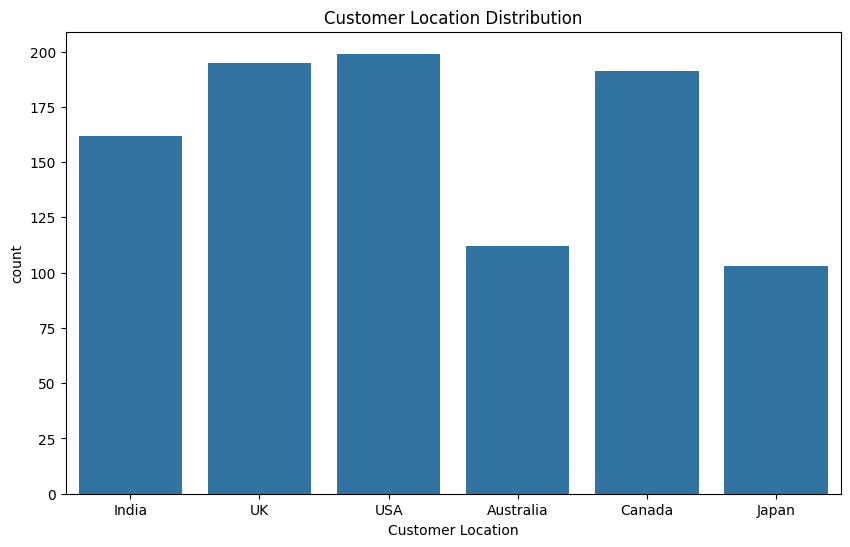

In [166]:
#Create some plots to explore our customer demographics

#Let's display the count of the customers for each location
fig, axes = plt.subplots(figsize=(10, 6))
sb.countplot(x='CustomerLocation', data=retail_sales)
axes.set_title('Customer Location Distribution')
axes.set_xlabel('Customer Location')

<ipython-input-177-41294614f7ed>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sb.barplot(x='CustomerLocation', y='SalesAmount', data=retail_sales, hue='ProductCategory', ci=None, estimator=sum)


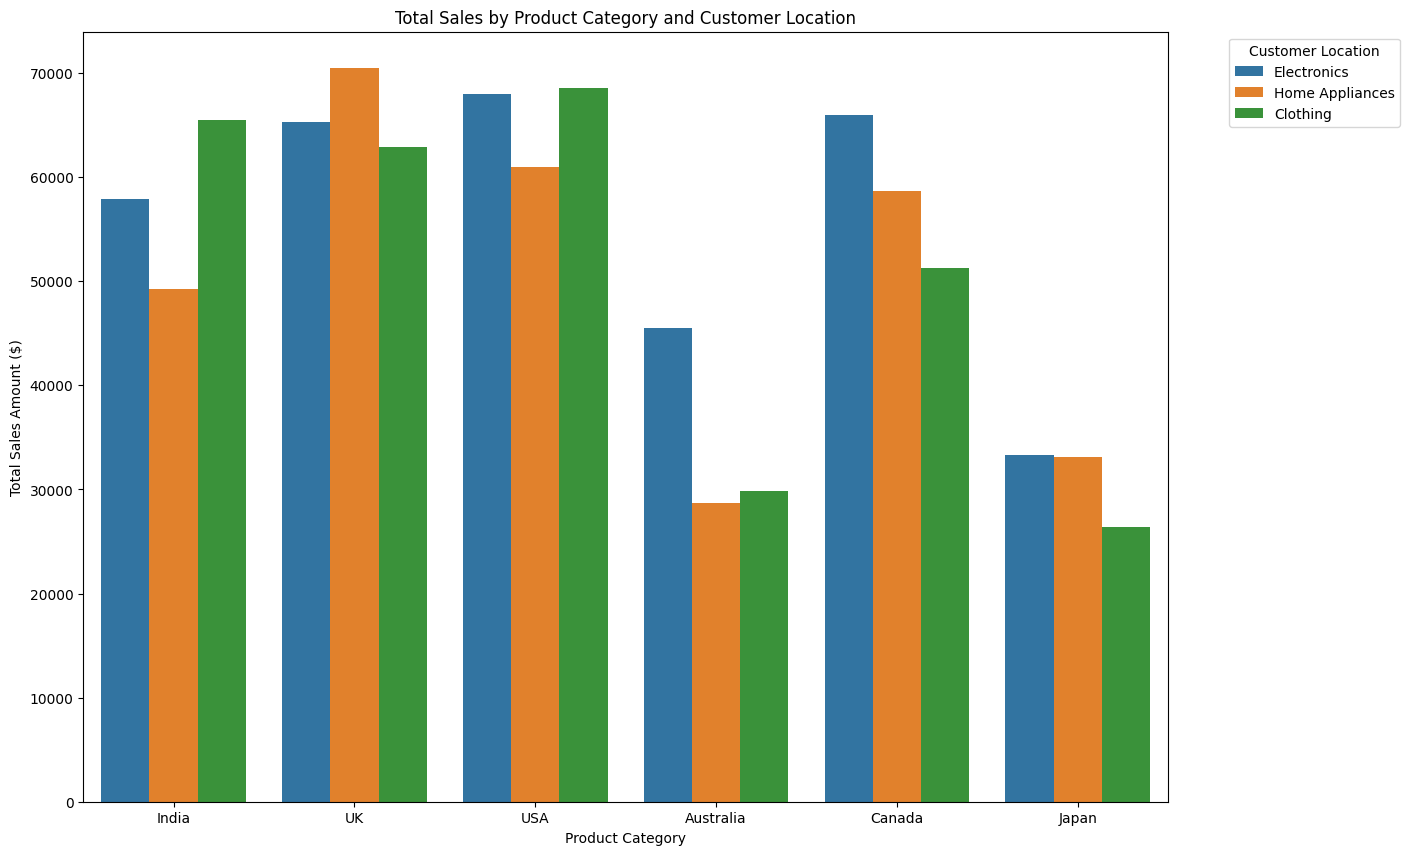

In [177]:
# Create a multi-faceted bar plot for sales by customer demographics
plt.figure(figsize=(14, 10))

# Sales by Product Category
sb.barplot(x='CustomerLocation', y='SalesAmount', data=retail_sales, hue='ProductCategory', ci=None, estimator=sum)

# Set labels and title
plt.title('Total Sales by Product Category and Customer Location')
plt.xlabel('Product Category')
plt.ylabel('Total Sales Amount ($)')

# Show legend
plt.legend(title='Customer Location', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [185]:
!pip install geocoder
!pip install geopy
!pip install statsmodels


In [179]:
import folium
from folium import plugins
from folium.plugins import HeatMap
import ipywidgets
#from ipyleaflet import Map, Marker, MarkerCluster, Heatmap
import geocoder
import geopy

In [183]:
location_sales = retail_sales.groupby(['CustomerLocation']).agg({'SalesAmount' : 'sum'}).reset_index()
mp = folium.Map(location=[41,-99], zoom_start=3.5)

loc =[]

location_list = retail_sales.CustomerLocation.unique().tolist()
for i in location_list:
    geo = geocoder.arcgis(i)
    val = location_sales.loc[location_sales['CustomerLocation'] ==i]['SalesAmount'].item()
    loc.append([geo.lat, geo.lng,val ])
    folium.Marker([geo.lat,geo.lng],
                  opacity=0,
                  tooltip = ('<body>Country: {} <br> Sales: {}M</body>'.format(i, round(val/1000000,3)))).add_to(mp)

HeatMap(loc).add_to(mp)
folium.LayerControl().add_to(mp)


mp

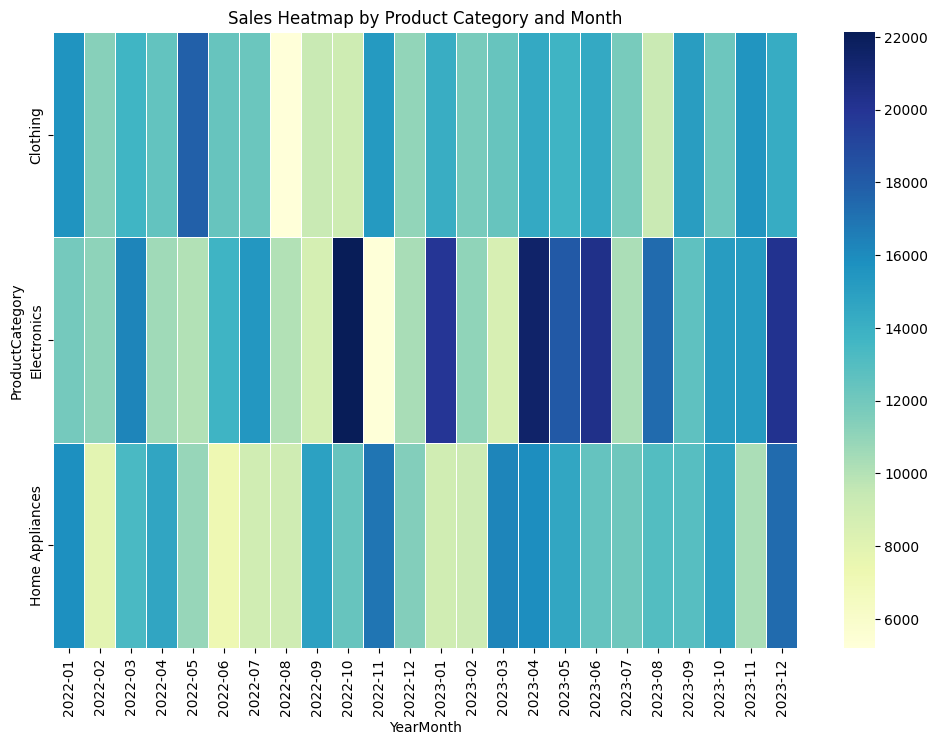

In [193]:
# Create a pivot table for the heatmap
heatmap_data = retail_sales.pivot_table(values='SalesAmount', index='ProductCategory', columns='YearMonth', aggfunc='sum')
# Create the heatmap
plt.figure(figsize=(12, 8))
sb.heatmap(heatmap_data, cmap='YlGnBu', annot=False, fmt=".0f", linewidths=.5)
plt.title('Sales Heatmap by Product Category and Month')
plt.show()

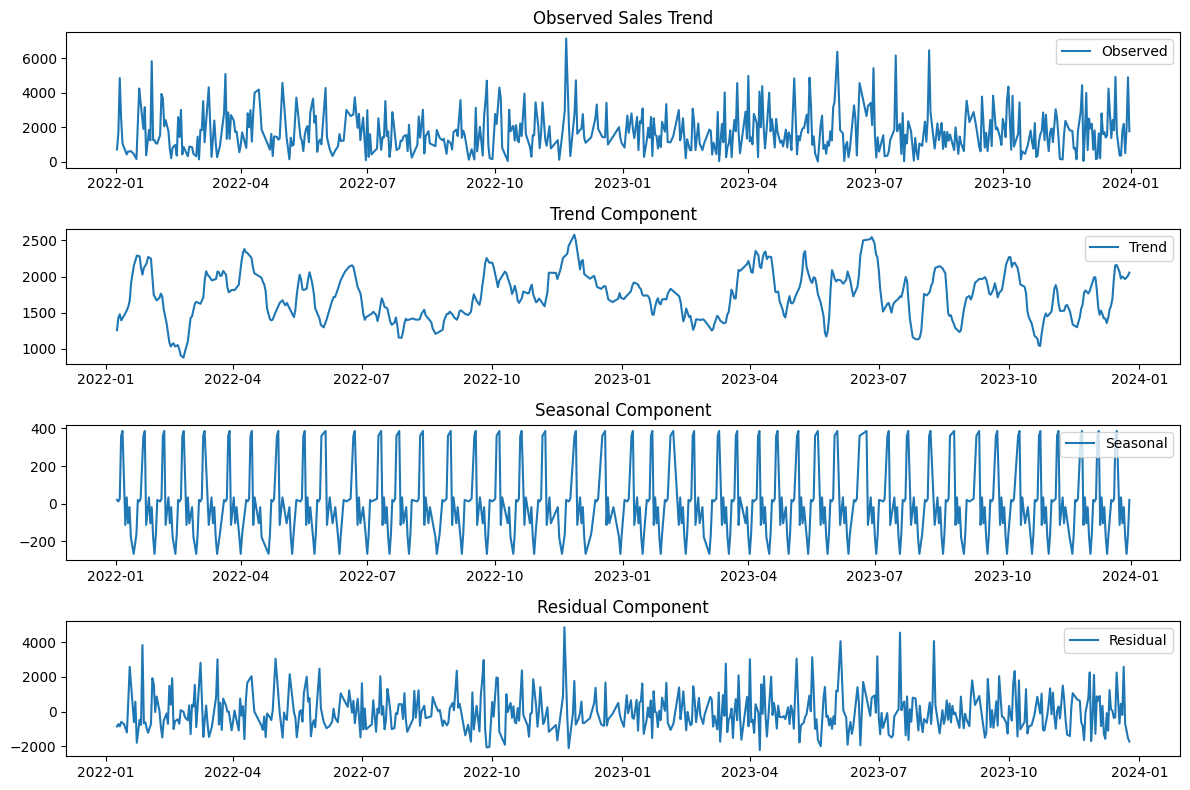

In [188]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Create a time series for seasonal decomposition
ts = retail_sales.groupby('SalesDate')['SalesAmount'].sum()

# Perform seasonal decomposition
result = seasonal_decompose(ts, model='additive', period=12)  # Assuming a yearly seasonality

# Plot the components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed')
plt.legend()
plt.title('Observed Sales Trend')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()
plt.title('Residual Component')

plt.tight_layout()
plt.show()

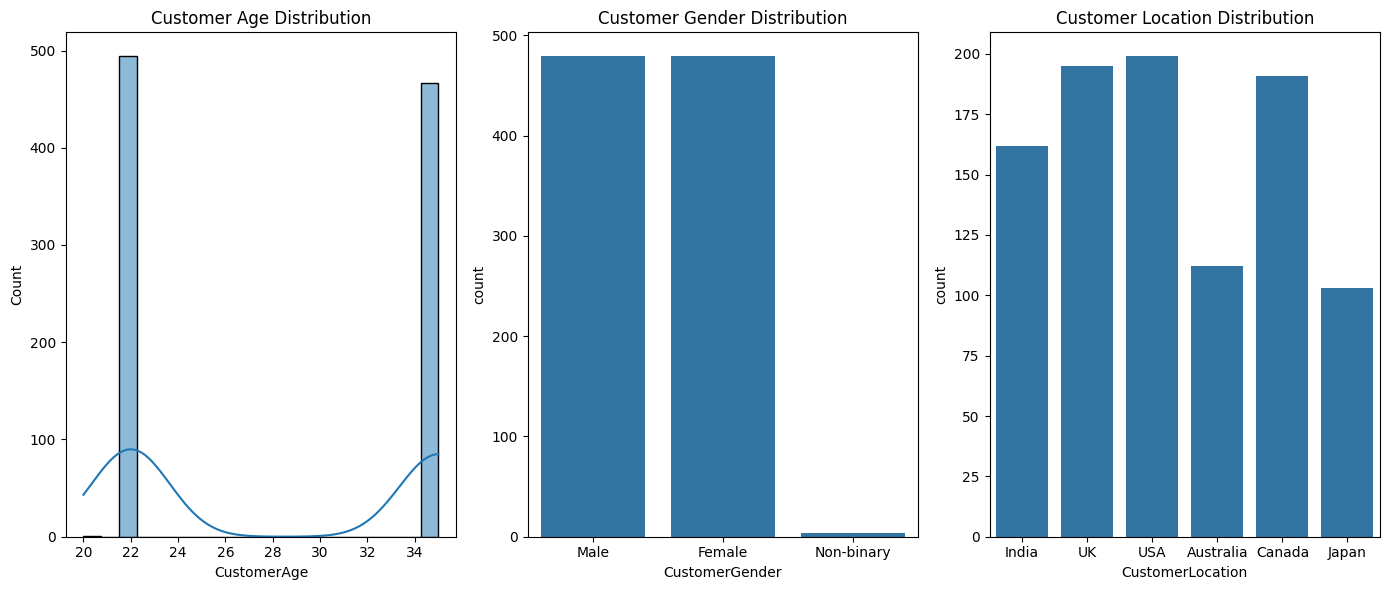

In [189]:
# Create a grid of histograms for customer demographics
plt.figure(figsize=(14, 6))

# Histogram for Customer Age
plt.subplot(1, 3, 1)
sb.histplot(retail_sales['CustomerAge'], bins=20, kde=True)
plt.title('Customer Age Distribution')

# Countplot for Customer Gender
plt.subplot(1, 3, 2)
sb.countplot(x='CustomerGender', data=retail_sales)
plt.title('Customer Gender Distribution')

# Countplot for Customer Location
plt.subplot(1, 3, 3)
sb.countplot(x='CustomerLocation', data=retail_sales)
plt.title('Customer Location Distribution')

# Adjust layout
plt.tight_layout()
plt.show()